##  Imports

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn import metrics

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from matplotlib import pyplot as plt

In [2]:
from data_handler.FaceMaskData import FaceMaskData
from data_handler.FaceMaskDataset import FaceMaskDataset
from trainer import *
from metrics.metrics import *

In [3]:
assert torch.cuda.is_available()

## Configurations

In [4]:
class CFG:
    seed = 42
    model_name = 'faster_rcnn'
    pretrained = True
    img_width = 480
    img_height = 480
    batch_size = 10
    n_epochs = 10
    n_folds = 1
    drop_rate = 0.9
    train_size = 0.85
    nms_thresh = 0.2
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    num_workers = 4
    num_classes = 4
    imgs_path = 'images'        #   images dir
    msks_path = 'annotations'   #   annotations dir

np.random.seed(CFG.seed)

## Data Load

Load the data into a dataset

In [5]:


faceMasksData = FaceMaskData(CFG.imgs_path, CFG.msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data(
                                                        train_size=CFG.train_size,
                                                        drop_rate=CFG.drop_rate,
                                                        seed=CFG.seed)

print('Training contains {} samples which is {:g}% of the data'.format(len(x_train), len(x_train) * 100 / (len(x_train) + len(x_test))))
print('Testing contains {} samples which is {:g}% of the data'.format(len(x_test), len(x_test) * 100 / (len(x_train) + len(x_test))))

-- The data loaded using drop_rate=0.9, therefore not all of the data will be loaded! --
Training contains 72 samples which is 84.7059% of the data
Testing contains 13 samples which is 15.2941% of the data


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
testset = FaceMaskDataset(x_test, y_test, CFG.imgs_path, CFG.msks_path, CFG.img_width, CFG.img_height, transforms=get_transformer('test'))
test_loader = DataLoader(dataset=testset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, collate_fn=collate_fn)

## Data Exploration

In [7]:
df = pd.read_csv(os.path.join(sys.path[0], 'annotation.csv'))
df.head()

xmin  ymin  xmax  ymax                   name             file  width  \
0    28    55    46    71              with_mask  maksssksksss737    400   
1    98    62   111    78              with_mask  maksssksksss737    400   
2   159    50   193    90  mask_weared_incorrect  maksssksksss737    400   
3   293    59   313    80              with_mask  maksssksksss737    400   
4   352    51   372    72              with_mask  maksssksksss737    400   

   height  class    Xcent     Ycent    boxW      boxH  
0     226      0  0.09250  0.278761  0.0450  0.070796  
1     226      0  0.26125  0.309735  0.0325  0.070796  
2     226      1  0.44000  0.309735  0.0850  0.176991  
3     226      0  0.75750  0.307522  0.0500  0.092920  
4     226      0  0.90500  0.272124  0.0500  0.092920

### Images and labels count

In [8]:
faces = len(df['file'].unique())
annotates = len(df)
print('There are total {} images in the data'.format(faces))
print('There are total {} annotated faces in the data'.format(annotates))
print('Average of {:.5f} per image'.format(annotates/faces))

There are total 853 images in the data
There are total 4072 annotated faces in the data
Average of 4.77374 per image


### Classes Distribution

label count
0              with_mask  3232
1           without_mask   717
2  mask_weared_incorrect   123

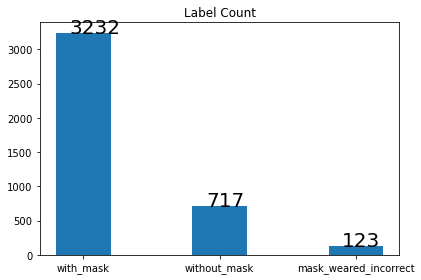

In [9]:
label_df = pd.DataFrame(columns=['label', 'count'])
for k, v in df['name'].value_counts().to_dict().items():
    label_df = label_df.append({'label':k, 'count':v}, ignore_index=True)
    
display(label_df)

fig, ax = plt.subplots()
ax.bar(label_df['label'], label_df['count'], width=0.4)
plt.title('Label Count')
for index, data in enumerate(label_df['count']):
    plt.text(x=index-0.1, y=data+1, s=data , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

### Classes Combinations Distribution

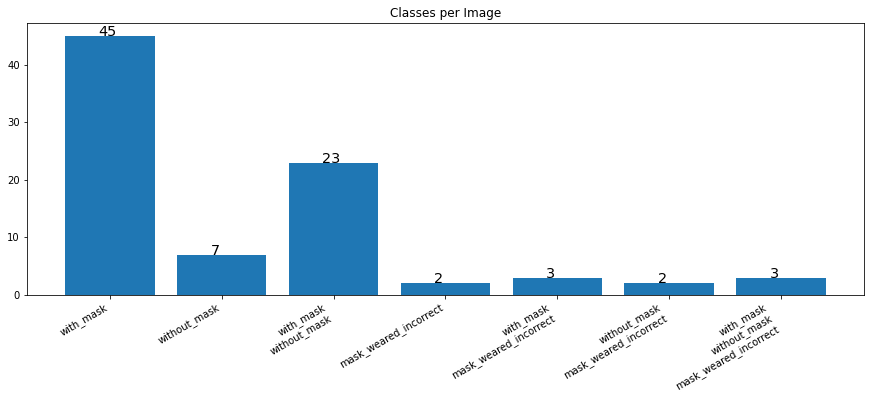

In [10]:
def get_class_distribute(df):
    classes = ["with_mask","without_mask","mask_weared_incorrect"]
    classes_bit_shifter_amount = {
        "with_mask":0,
        "without_mask":1,
        "mask_weared_incorrect":2,
    }
    
    dists = np.zeros(8)
    for name in faceMasksData.images:
        img_name = name.split('.')[0]
        img_classes = df[df['file']==img_name]['name'].unique()
        index = 0
        for cls in img_classes:
            index |= 1 << classes_bit_shifter_amount[cls]
            
        dists[index] += 1
    if dists[0] == 0:
        return dists[1:]
    return dists
            

dist_names = ['None', 'with_mask', 'without_mask', 'with_mask\nwithout_mask',
              'mask_weared_incorrect', 'with_mask\nmask_weared_incorrect',
              'without_mask\nmask_weared_incorrect',
              'with_mask\nwithout_mask\nmask_weared_incorrect']

dist_values = get_class_distribute(df)
if len(dist_values) == 7:
    dist_names = dist_names[1:]

plt.figure(figsize=(15, 5))
axs = plt.bar(dist_names, dist_values)
for ax in axs:
    plt.text(ax.get_xy()[0] + 0.3, ax.get_height(), int(ax.get_height()), fontsize='x-large')
plt.xticks(rotation=30, ha='right')
plt.title('Classes per Image')
plt.show()

We can understand from these two cahrts that the data is very imbalanced.  
For example, there are only 123 faces with an incorrect weared mask, those faces appearing in (21 + 30 + 4 + 42) = 97 images, which is (97 / 853) = 11% of the total data.  
Unlike faces with masks which appearing in (768 / 853) = 90% of the data.  
Therefore, in advanced part of the training, we will have to split the train and validation sets in a good manager.

### Number of Faces per Image

In [11]:
def get_num_faces(df, image_name_col):
    max_faces = find_max_faces(df,image_name_col)
    arr = [0] * (max_faces + 1)
    faces_count =1
    current_img =df.at[0,image_name_col]
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
            faces_count = faces_count + 1
        else:
            arr[faces_count] = arr[faces_count] +1
            faces_count =1
            current_img =df.at[i,image_name_col]
    
    df = pd.DataFrame(columns=['faces', 'count'])
    for i, val in enumerate(arr):
        if val > 0:
            df = df.append({'faces': i, 'count': val}, ignore_index=True)
    return df

def find_max_faces(df,image_name_col):
    max_faces=1
    faces_count =1
    current_img =df.at[0,image_name_col]  
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
          faces_count = faces_count +1
        else:
            if faces_count > max_faces:
                max_faces = faces_count
            current_img = df.at[i,image_name_col]  
            faces_count =1
    return max_faces

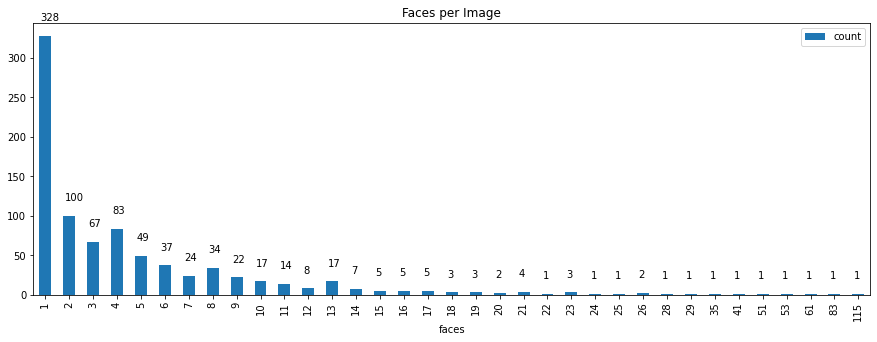

In [12]:
face_dist_df = get_num_faces(df, 'file')

ax = face_dist_df.plot.bar(x='faces', y='count', figsize=(15,5), title='Faces per Image')
for idx, label in enumerate(list(face_dist_df.faces)): 
    val = int(face_dist_df[face_dist_df['faces']==label]['count'])
    ax.annotate(val,
                (idx-0.2, val),
                 xytext=(0, 15), 
                     textcoords='offset points')

In [13]:
print('STD of faces in the images: {:.5}'.format(face_dist_df['count'].std()))

STD of faces in the images: 58.229


### Train Examples

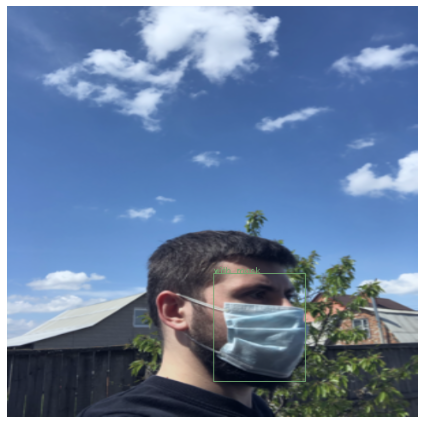

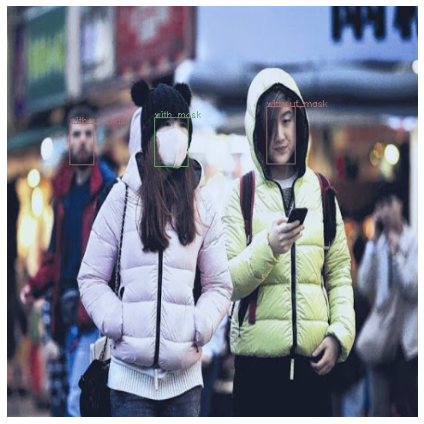

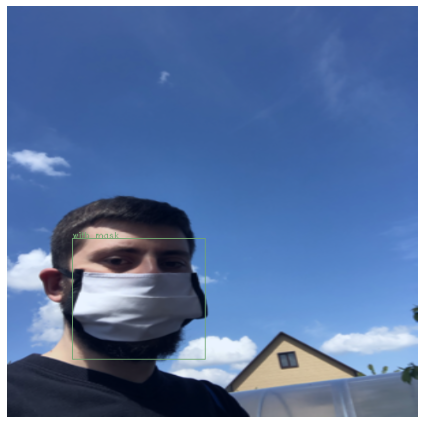

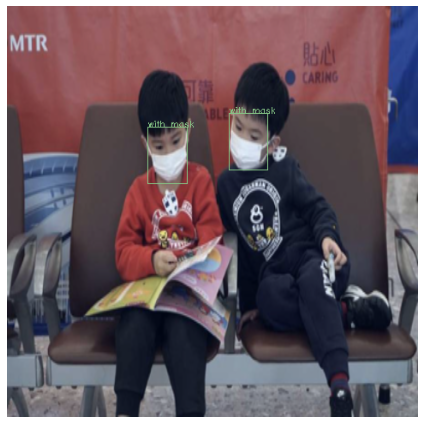

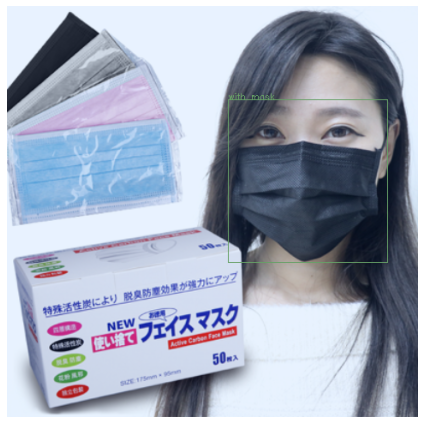

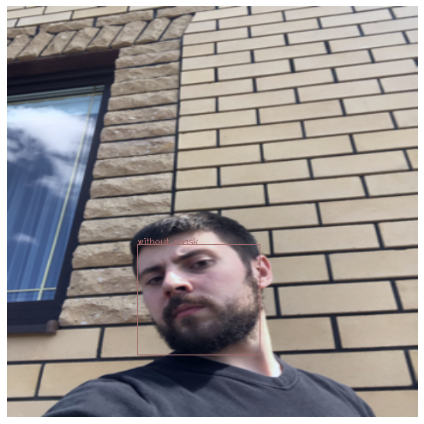

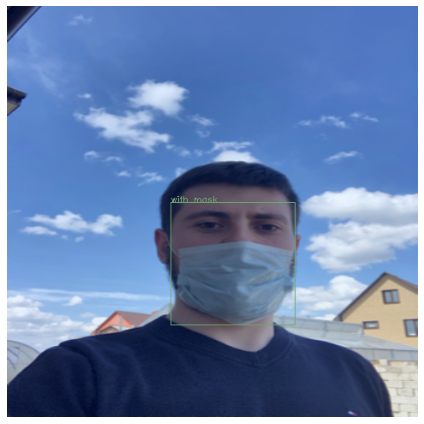

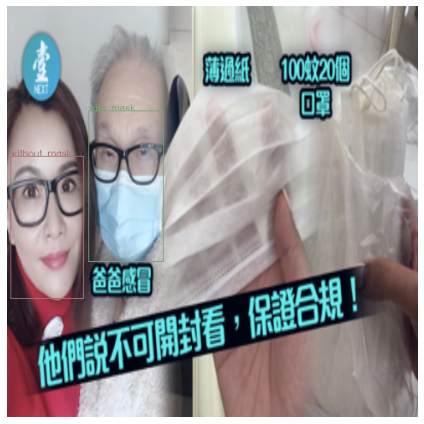

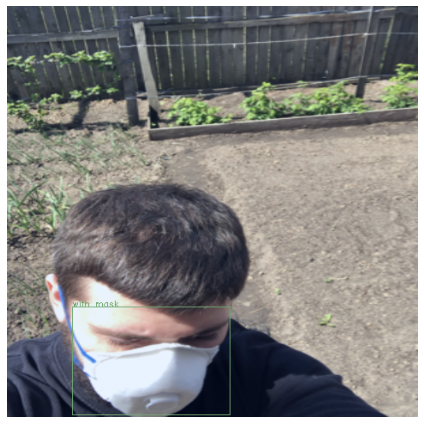

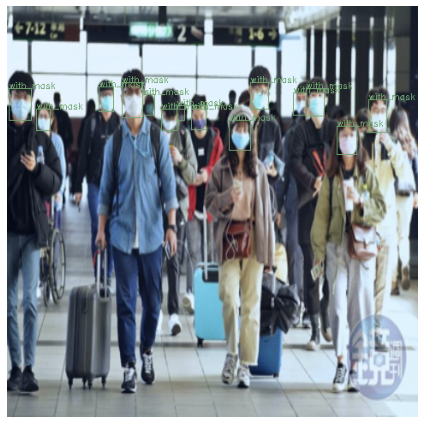

In [14]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def get_annotated_img(img, annt, is_pred=False):
    img = np.array(np.transpose(img, (1, 2, 0))) * 255.0    #   multiple by 255 as in the dataset we divide it
                                                                #   needed here because the image come from the dataset in values of [0, 1]
                                                                #   and the annotations are in values of [0, 255] and plt should get images
                                                                #   with values of [0, 1], therefore a normalizing of the images is needed
        
    for box, cat in zip(annt['boxes'], annt['labels']):
        xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
#         [None, 'without_mask','with_mask','mask_weared_incorrect']
        color = (0, 0, 0)
        if cat == 2:
            color = (0, 255, 0) # green
        elif cat == 3:
            color = (0, 0, 255) # blue
        elif cat == 1:
            color = (255, 0, 0) # red
        thickness = 1
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1 / 3
        if not is_pred:
            img = cv2.putText(img, '{}'.format(faceMasksData.classes[cat]), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        else:
            img = cv2.putText(img, '{} {:.5f}'.format(faceMasksData.classes[cat], annt['scores']), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        
        
    return img

def show_augmented_samples(dataloader, model=None):    
    samples, annotations = next(iter(dataloader))   #   get the first batch

    amount_samples = min(12, len(samples))          #   number of examples will be at most 12

    for i, (img, ant) in enumerate(zip(samples, annotations)):
        if i >= amount_samples:
            break
        plt.figure(figsize=(6, 6))
#         plt.subplot(amount_samples, 1, i + 1)        
        img = get_annotated_img(img, ant)
        plt.imshow(norm(img))  
        plt.axis('off')
        plt.tight_layout()
        plt.show()

show_augmented_samples(test_loader)

## Training

In [15]:
def get_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #   get model
    in_features = model.roi_heads.box_predictor.cls_score.in_features                   #   get input size of last layer
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)         #   regenerate the last layer
    return model

In [16]:
model = get_model(num_classes=CFG.num_classes, pretrained=CFG.pretrained)

In [17]:
params = [p for p in model.parameters() if p.requires_grad]         #   get optimizeable paramaters
# optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = optim.ASGD(params)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [18]:
datetime_srt = datetime.today().strftime("%d-%m-%y_%H:%M")
run_path = os.path.join(sys.path[0], 'runs', datetime_srt)

In [19]:
# train(model, dataloaders, optimizer, run_path, CFG, scheduler)
train(model, x_train, y_train, optimizer, run_path, CFG, scheduler)


This running path is: `/home/linuxgpu/anaconda3/envs/lab_1/files/runs/30-10-21_15:47`

Epoch   1 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]

train:	loss_classifier=3.55218	loss_box_reg=1.15886	loss_objectness=3.00632	loss_rpn_box_reg=0.26806	total loss=7.98542
valid:	loss_classifier=0.57777	loss_box_reg=0.50353	loss_objectness=0.11102	loss_rpn_box_reg=0.06226	total loss=1.25458



Model saved. Loss < PrevLoss (1.25458 < 10000.00000)
Epoch   2 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s]

train:	loss_classifier=2.17580	loss_box_reg=2.30775	loss_objectness=0.56699	loss_rpn_box_reg=0.16746	total loss=5.21800
valid:	loss_classifier=0.45187	loss_box_reg=0.48371	loss_objectness=0.09237	loss_rpn_box_reg=0.05555	total loss=1.08351



Model saved. Loss < PrevLoss (1.08351 < 1.25458)
Epoch   3 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

train:	loss_classifier=1.91080	loss_box_reg=2.18068	loss_objectness=0.35479	loss_rpn_box_reg=0.13540	total loss=4.58168
valid:	loss_classifier=0.41024	loss_box_reg=0.49565	loss_objectness=0.08102	loss_rpn_box_reg=0.05336	total loss=1.04026



Model saved. Loss < PrevLoss (1.04026 < 1.08351)
Epoch   4 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]

train:	loss_classifier=1.64340	loss_box_reg=1.97522	loss_objectness=0.26566	loss_rpn_box_reg=0.11999	total loss=4.00427
valid:	loss_classifier=0.39031	loss_box_reg=0.52176	loss_objectness=0.07639	loss_rpn_box_reg=0.05318	total loss=1.04164



Epoch   5 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

train:	loss_classifier=1.65657	loss_box_reg=2.30209	loss_objectness=0.24640	loss_rpn_box_reg=0.14268	total loss=4.34773
valid:	loss_classifier=0.34945	loss_box_reg=0.49919	loss_objectness=0.07919	loss_rpn_box_reg=0.05069	total loss=0.97853



Model saved. Loss < PrevLoss (0.97853 < 1.04026)
Epoch   6 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]

train:	loss_classifier=1.54725	loss_box_reg=2.26252	loss_objectness=0.19332	loss_rpn_box_reg=0.13329	total loss=4.13639
valid:	loss_classifier=0.34847	loss_box_reg=0.51457	loss_objectness=0.09787	loss_rpn_box_reg=0.05053	total loss=1.01144



Epoch   7 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]

train:	loss_classifier=1.39396	loss_box_reg=1.94845	loss_objectness=0.18593	loss_rpn_box_reg=0.11128	total loss=3.63961
valid:	loss_classifier=0.32652	loss_box_reg=0.49582	loss_objectness=0.07890	loss_rpn_box_reg=0.04949	total loss=0.95073



Model saved. Loss < PrevLoss (0.95073 < 0.97853)
Epoch   8 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]

train:	loss_classifier=1.37200	loss_box_reg=1.99195	loss_objectness=0.14029	loss_rpn_box_reg=0.10007	total loss=3.60431
valid:	loss_classifier=0.33020	loss_box_reg=0.51740	loss_objectness=0.07022	loss_rpn_box_reg=0.04926	total loss=0.96707



Epoch   9 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]

train:	loss_classifier=1.32390	loss_box_reg=2.00729	loss_objectness=0.12949	loss_rpn_box_reg=0.09864	total loss=3.55931
valid:	loss_classifier=0.31119	loss_box_reg=0.49553	loss_objectness=0.09025	loss_rpn_box_reg=0.04863	total loss=0.94560



Model saved. Loss < PrevLoss (0.94560 < 0.95073)
Epoch  10 of 10:


valid: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]

train:	loss_classifier=1.50949	loss_box_reg=2.35980	loss_objectness=0.12509	loss_rpn_box_reg=0.14518	total loss=4.13955
valid:	loss_classifier=0.35978	loss_box_reg=0.49086	loss_objectness=0.09632	loss_rpn_box_reg=0.05043	total loss=0.99740



In [20]:
# run_path = os.path.join(sys.path[0], 'runs', '27-10-21_20:27')
# print(run_path)

In [21]:
# model_path = os.path.join(run_path, 'models', 'faster_rcnn_model.pth')
# model = get_model(4)
# model.load_state_dict(torch.load(model_path))

## Evaluation

### Examples

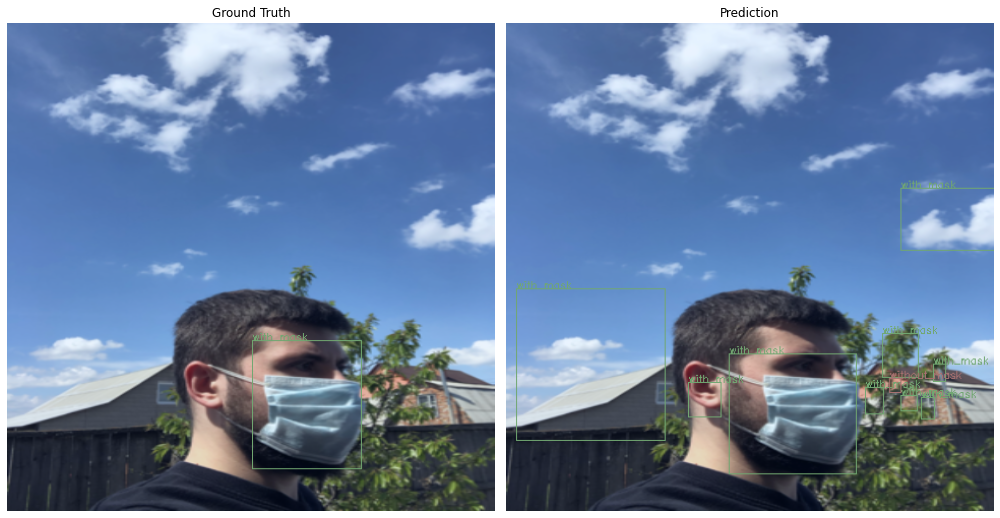

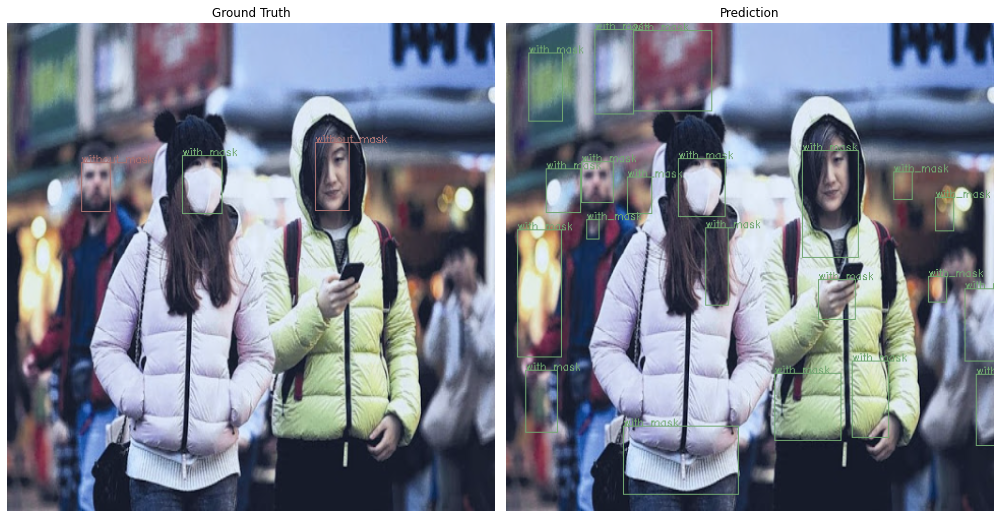

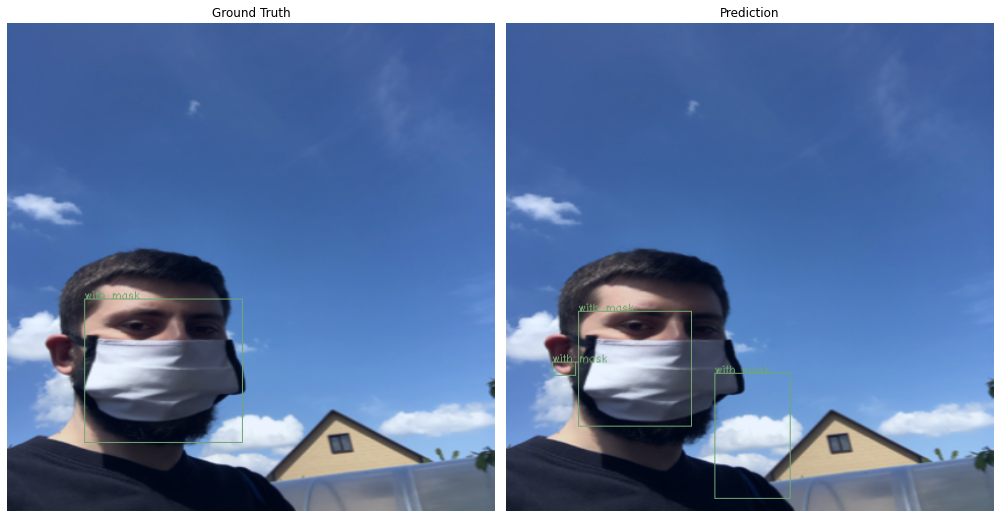

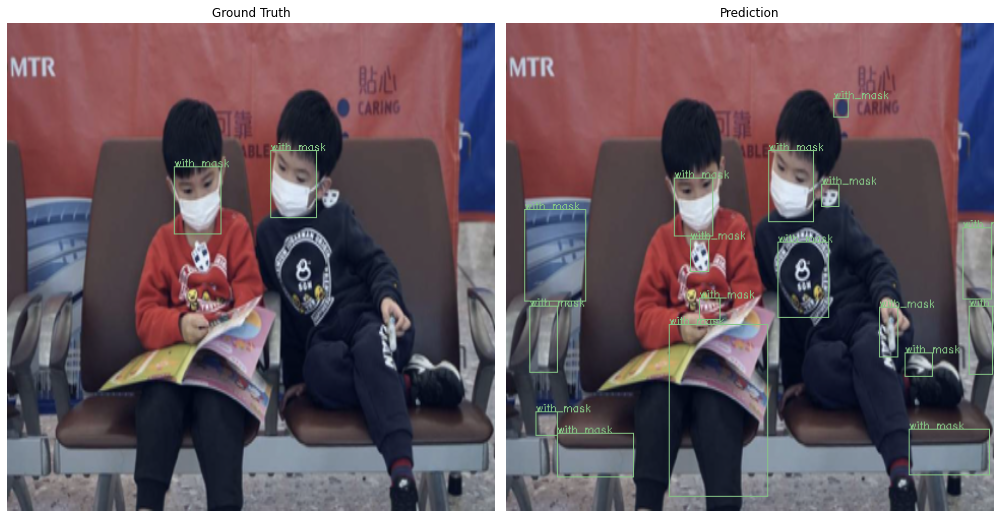

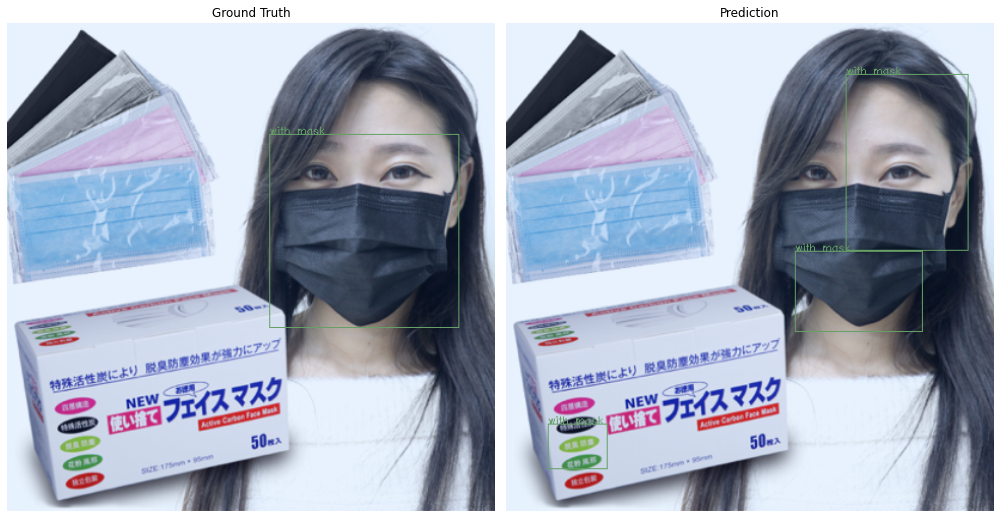

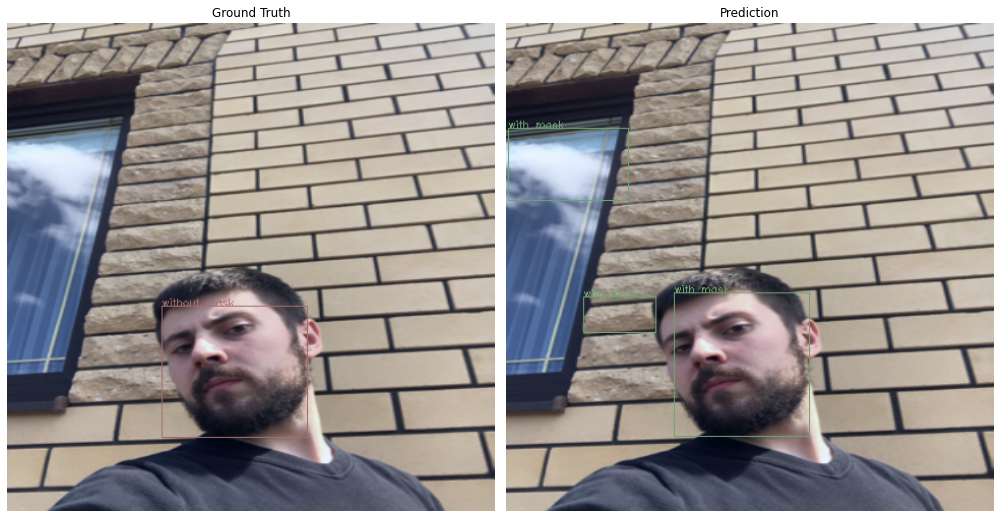

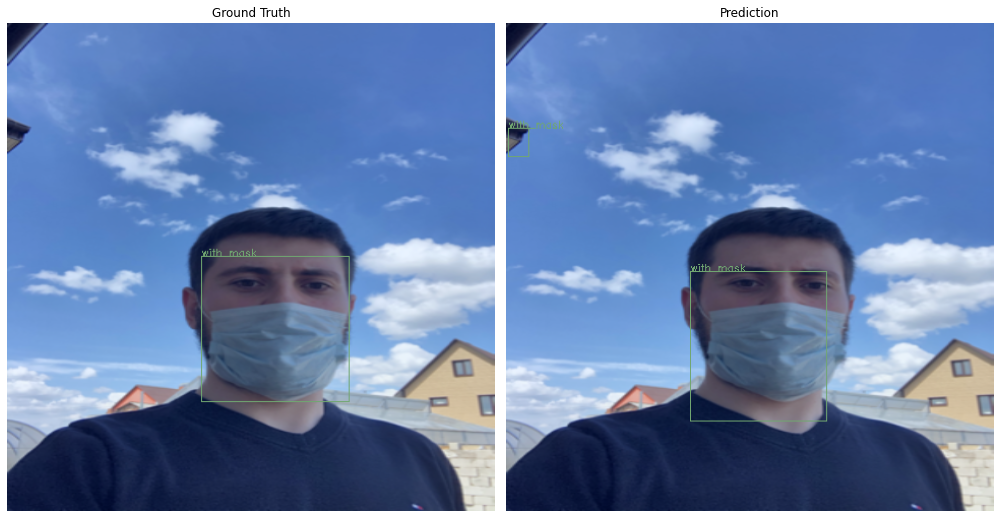

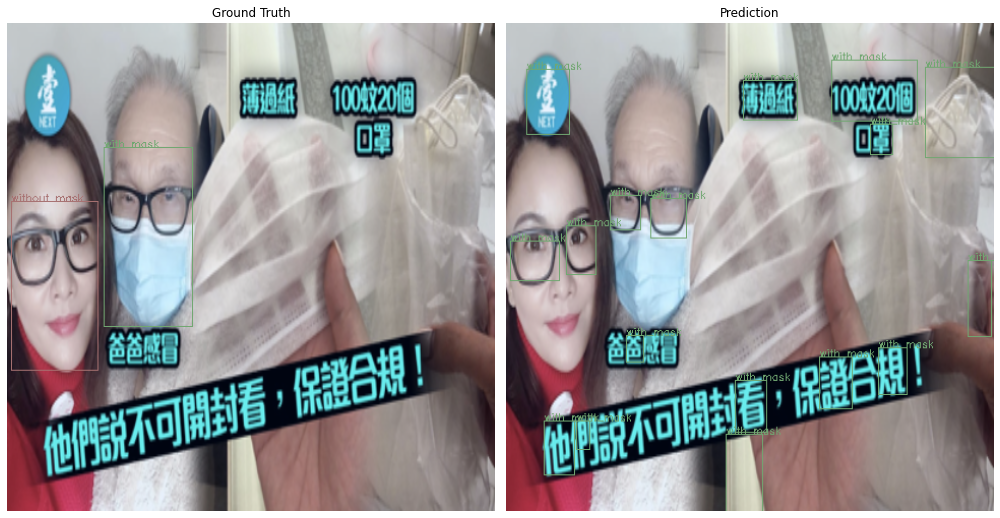

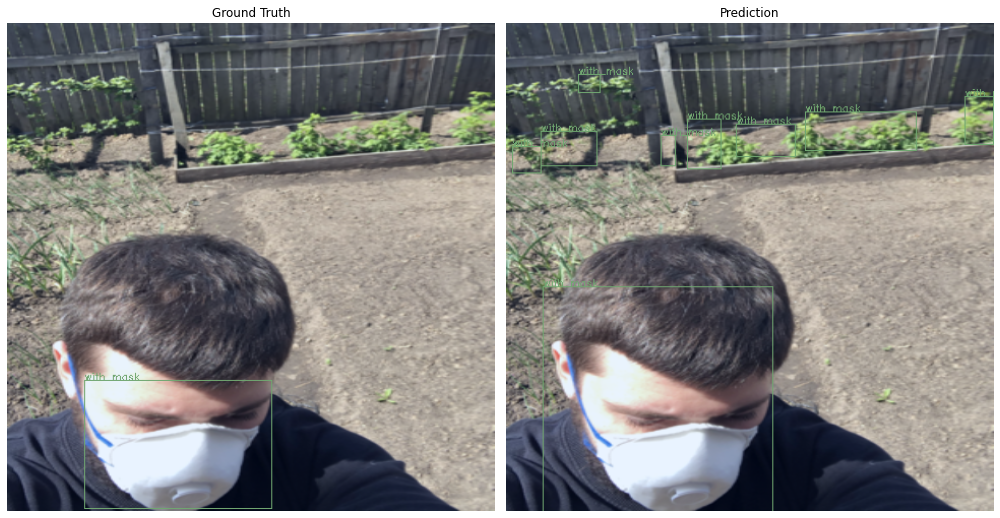

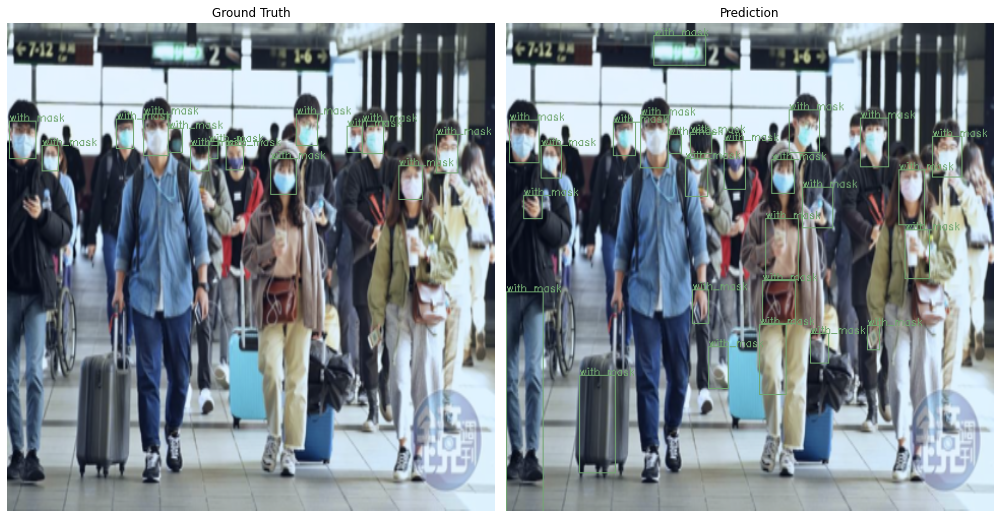

In [34]:
def plot_test_examples(model, loader, threshold):
    device = CFG.device
    model = model.to(device).eval()

    imgs, annts = next(iter(loader))
    imgs  = list(img.to(device) for img in imgs)

    output = model(imgs)

    amount_samples = min(12, len(imgs))          #   number of examples will be at most 12

    for i, (img, ant, pred) in enumerate(zip(imgs, annts, output)):
        if i >= amount_samples:
            break
            
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 60))

        axes[0].set_title('Ground Truth')
        axes[1].set_title('Prediction')

        axes[0].axis('off')
        axes[1].axis('off')

        annot_img = get_annotated_img(img.cpu().detach().numpy(), ant)
        axes[0].imshow(norm(annot_img))          

        pred_thrs = get_pred_by_threshold(pred, threshold)
        pred_cpu = {k: v.cpu().detach().numpy() for k, v in pred_thrs.items()}
        
        annot_img = get_annotated_img(img.cpu().detach().numpy(), pred_cpu)
        axes[1].imshow(norm(annot_img))  

        fig.tight_layout()
        plt.show()

    del imgs, pred, pred_thrs
    torch.cuda.empty_cache()

plot_test_examples(model, test_loader, threshold=0.1)

In [23]:
# plot_test_examples(model, dataloaders['train'])


In [24]:
# from torchmetrics import MAP

# # def evaluate_single_image(pred, real):

# def evaluate(model, loader, nms_thresh):
       
#     device = CFG.device
#     model = model.to(device).eval()
    
#     mAP = MAP(class_metrics=True)
    
#     with tqdm(total=len(loader), desc='evaluating') as progress_bar:               #   define progress bas
#         for img_batch, target_batch in loader:
#             img_batch  = list(img.to(device) for img in img_batch)
# #             target_batch = [{k: v.to(device) for k, v in t.items()} for t in target_batch]

#             output_batch = model(img_batch)
#             output_batch = get_pred_by_threshold_batch(output_batch, nms_thresh)
            
#             output_batch_cpu = [{k: v.cpu().detach() for k, v in t.items()} for t in output_batch]

#             mAP.update(output_batch_cpu, target_batch)

#     #         for target, output in zip(target_batch, output_batch):
#     #             output = get_pred_by_threshold(output, nms_thresh)

#     #             print(torchvision.ops.box_iou(output['boxes'], target['boxes']))



#     #             del target, output


#     #         print(output)
#     #         print('\n\n')
#     #         print(target_batch)

#     #         tp or fp = conf > thrsh and class_pred == class_real and iou > thresh

#             del img_batch, target_batch, output_batch, output_batch_cpu
#             torch.cuda.empty_cache()
#             progress_bar.update(1)
    
#     return mAP.compute()
# #     output = get_pred_by_threshold(output[0], 0.1)
# # #     output = torchvision.ops.batched_nms(boxes: , scores: , idxs: , iou_threshold: float)
# #     print(torchvision.ops.box_iou(output['boxes'], annts['boxes']))

    
    
# # print(evaluate(model, dataloaders['valid'], 0.2))

### mAP@[0.5:0.05:0.95]

In [25]:
def plot_precision_recall(df, iou_thresh):
    
    auc_dict = dict()
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    plt.title('IOU Threshold {:.3f}'.format(iou_thresh))
    
    for idx, c in enumerate(df['real_class'].unique()):
        
        prec = df[df['real_class']==c]['precision']
        recall = df[df['real_class']==c]['recall']
        
        auc = metrics.auc(x=recall, y=prec)
        auc_dict[c] = auc
        axes[idx].plot(recall, prec)
        axes[idx].set_title('Class {} AP={:.5f}'.format(faceMasksData.classes[c], auc))
        axes[idx].grid()
        axes[idx].set_ylabel('Precision')
        axes[idx].set_xlabel('Recall')
        
    fig.tight_layout()
    plt.show()    
    
    return auc_dict

evaluating IOU: 100%|█████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


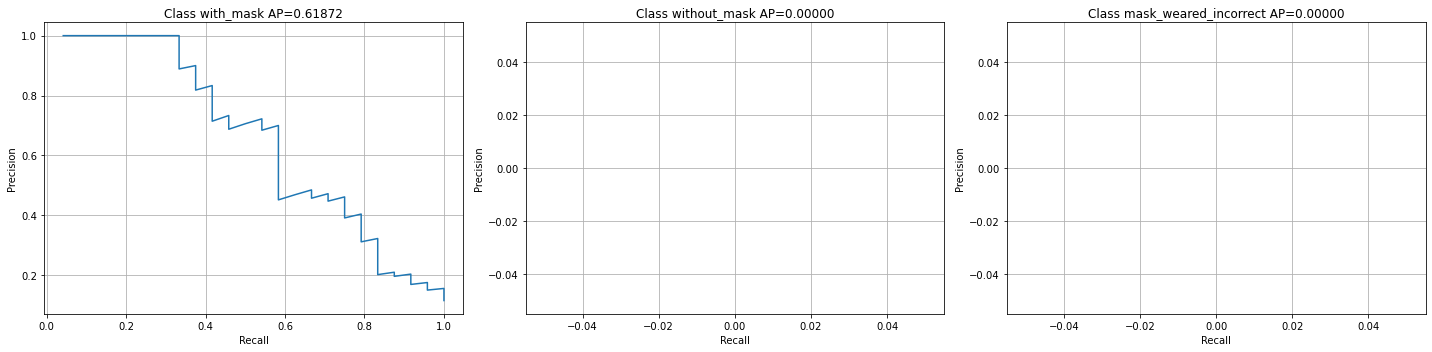

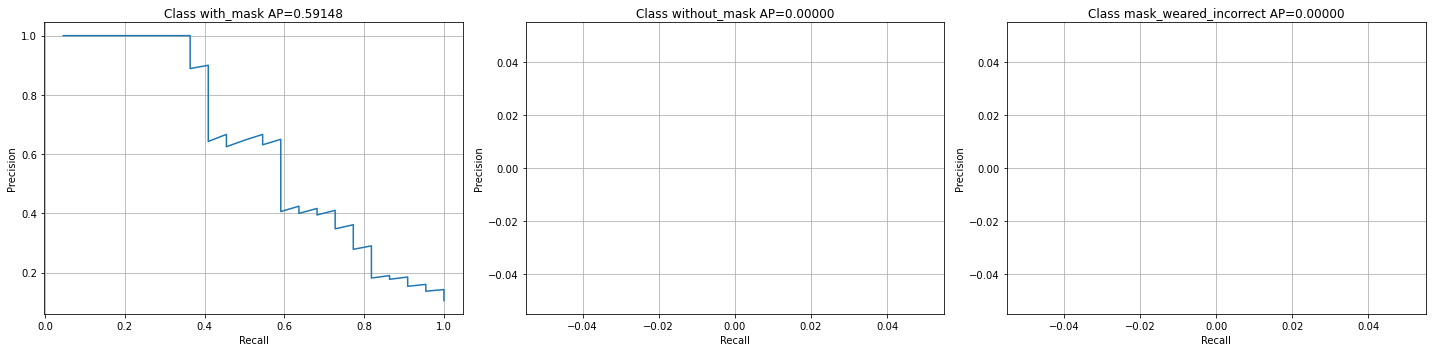

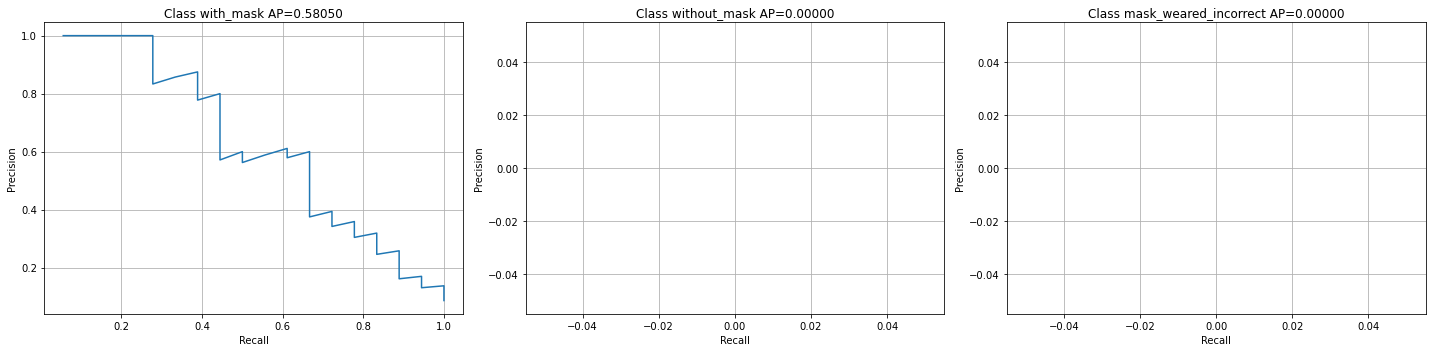

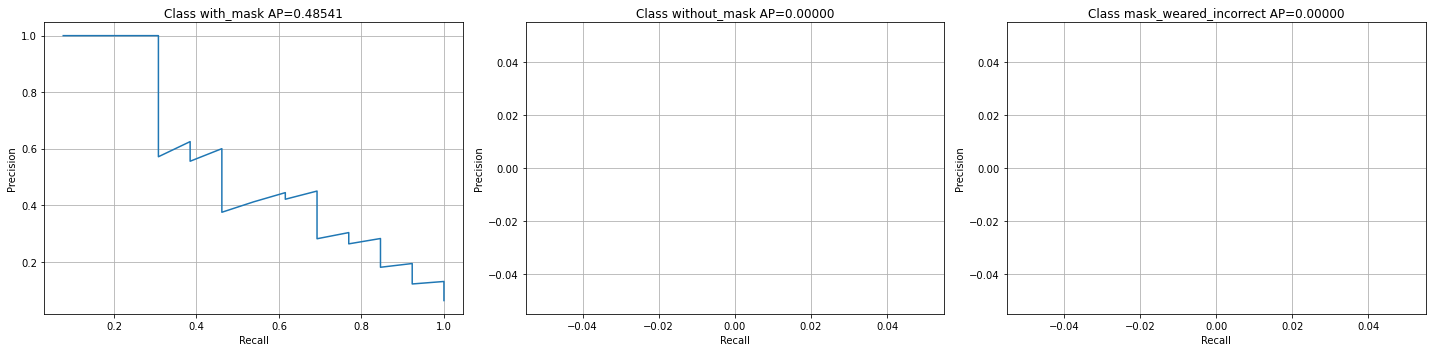

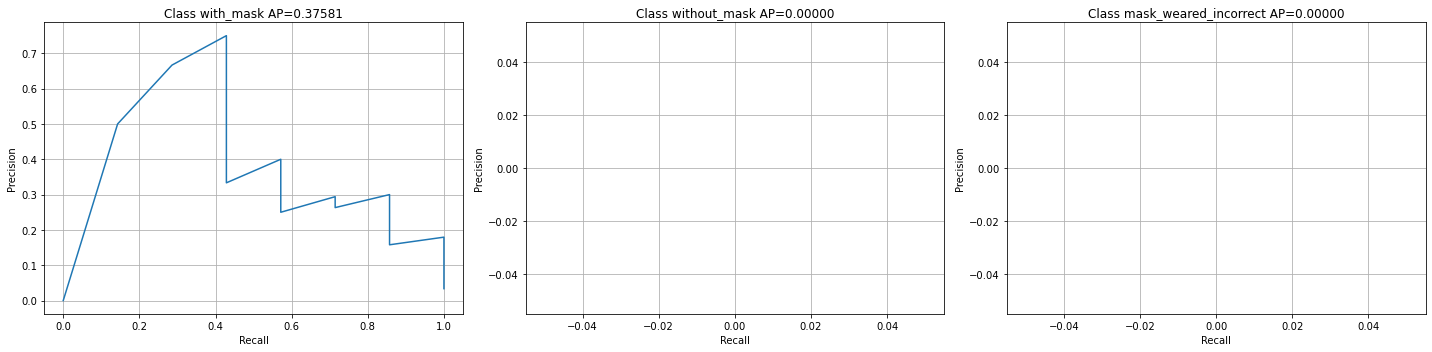

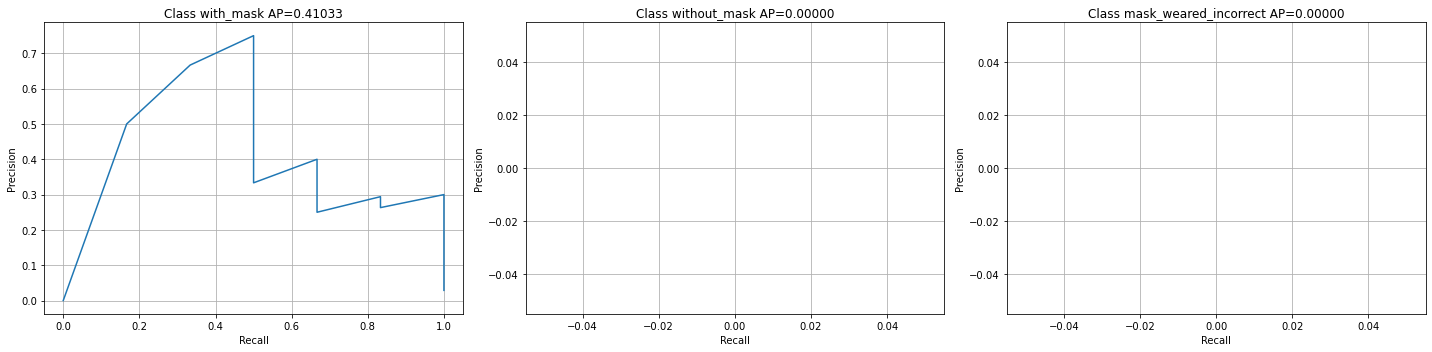

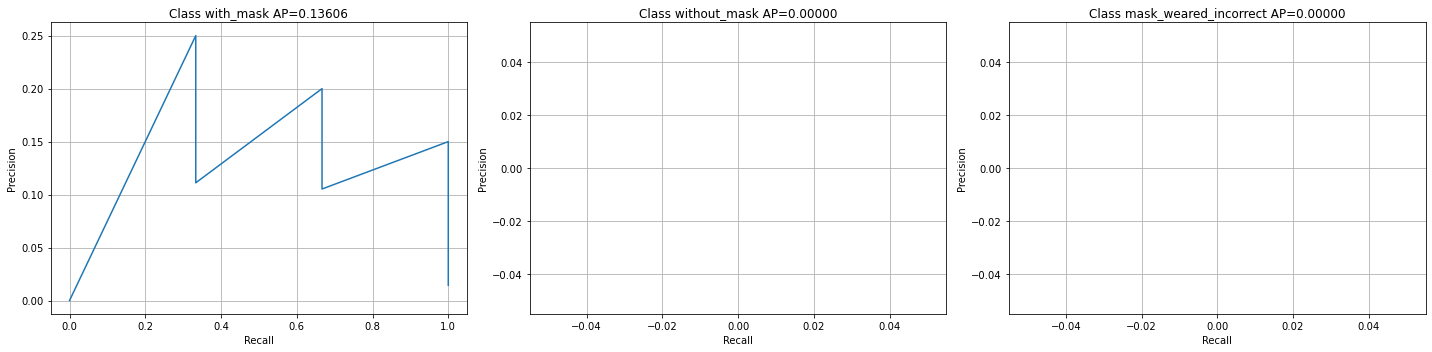

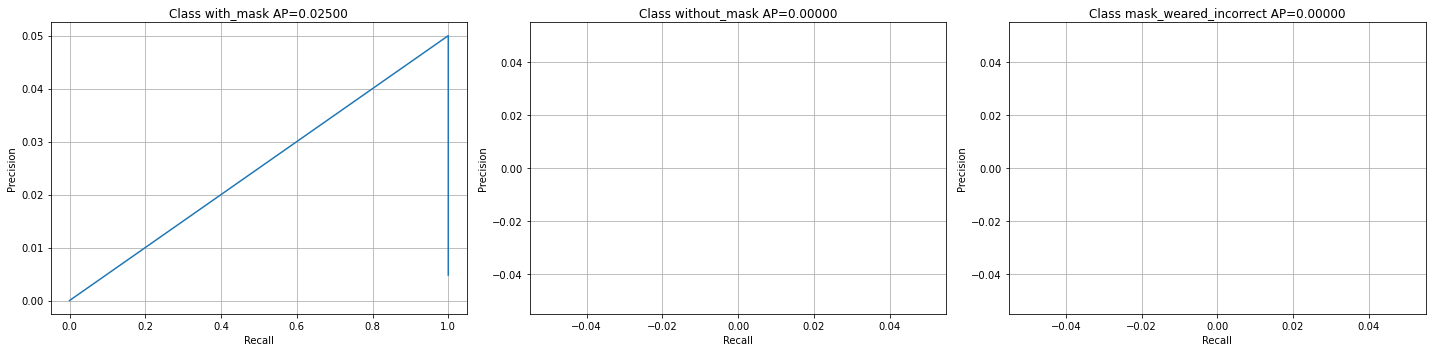

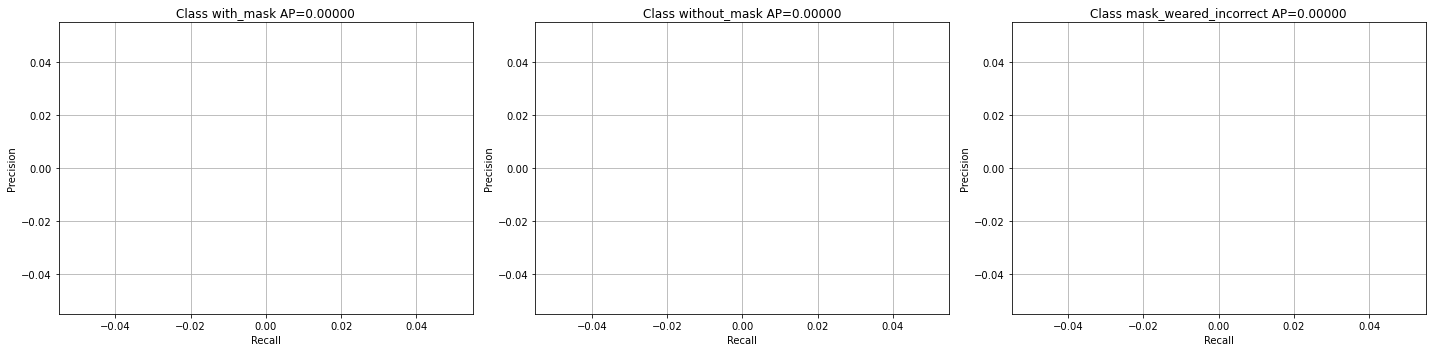

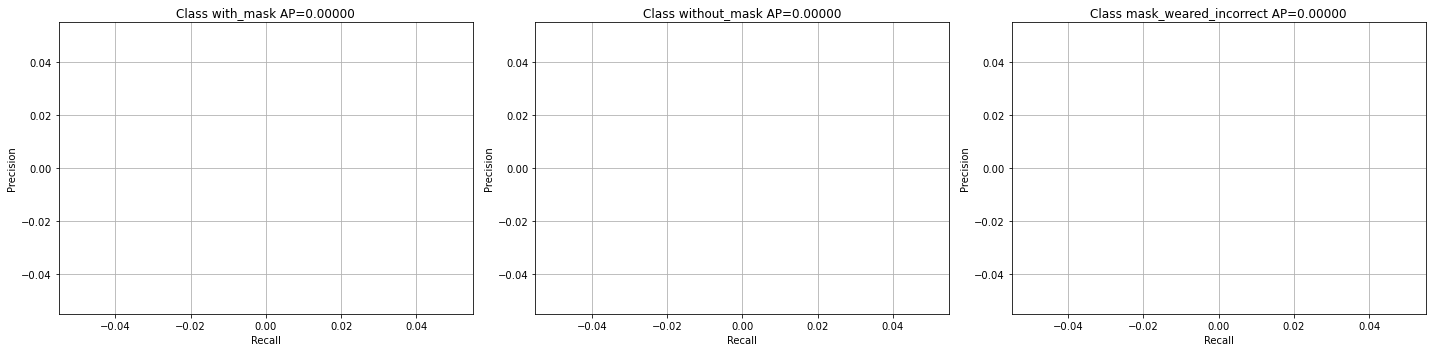

In [26]:
def evaluate2(model, loader, nms_thresh, iou_start=0.5, iou_step=0.05, iou_end=0.95, eps=1e-6):
       
    metrics_path = '{}/metrics'.format(run_path)
    df = get_iou_as_df(model, loader, nms_thresh)
    auc_dict = dict()
    
    for iou_trsh in np.arange(iou_start, iou_end + iou_step, iou_step):
        
        df = calc_precision_recall(df, iou_trsh, metrics_path)
        auc_dict[iou_trsh] = plot_precision_recall(df, iou_trsh)
    
    return auc_dict

auc_dict = evaluate2(model, test_loader, CFG.nms_thresh)

In [27]:
iou_tot = dict()

for iou in auc_dict:
    iou_sum = sum(auc_dict[iou].values())
    mAP = iou_sum / len(auc_dict[iou])
    iou_tot[iou] = mAP
    print('mAP@{:.3} =\t{:.5}'.format(iou, mAP))
    

mAP@0.5 =	0.20624
mAP@0.55 =	0.19716
mAP@0.6 =	0.1935
mAP@0.65 =	0.1618
mAP@0.7 =	0.12527
mAP@0.75 =	0.13678
mAP@0.8 =	0.045354
mAP@0.85 =	0.0083333
mAP@0.9 =	0.0
mAP@0.95 =	0.0


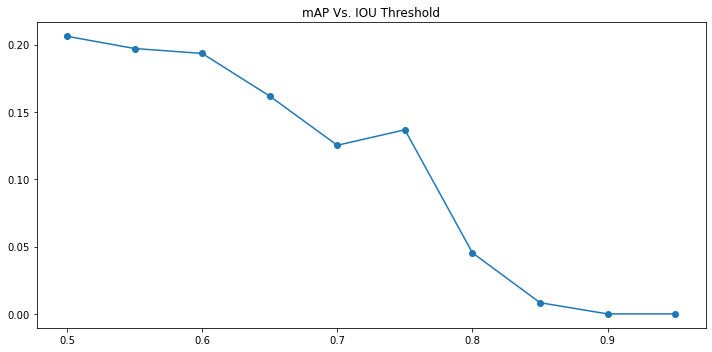

In [28]:
x, y = zip(*sorted(iou_tot.items()))

plt.figure(figsize=(10, 5))
plt.title('mAP Vs. IOU Threshold')
plt.plot(x, y, marker='o')
plt.tight_layout()
plt.show()

In [29]:
mAP_classes = { c: .0 for c in auc_dict[0.5] }
total_mAP = .0

for iou, iou_dict in auc_dict.items():
    for c, val in iou_dict.items():
        mAP_classes[c] += val
        
for c in mAP_classes:
    mAP_classes[c] /= len(auc_dict)
    total_mAP += mAP_classes[c]
    print('{}\t\tmAP@[0.5:0.05:0.95] =\t{:.5f}'.format(faceMasksData.classes[c], mAP_classes[c]))
    
total_mAP /= len(mAP_classes)
print('Total mAP@[0.5:0.05:0.95] =\t{:.5f}'.format(total_mAP))

with_mask		mAP@[0.5:0.05:0.95] =	0.32233
without_mask		mAP@[0.5:0.05:0.95] =	0.00000
mask_weared_incorrect		mAP@[0.5:0.05:0.95] =	0.00000
Total mAP@[0.5:0.05:0.95] =	0.10744
